# Notebook magique with AutoML

TO DO:
- remove outliers: implement new fucntion + get right percentage
- test different numbers of topics and clusters 

See 
https://github.com/parklize/cikm2020-analyticup?fbclid=IwAR0Ti_pF7HrIO5ELFlvA1b2FEL_D68xlu_XdXeFxyARzBfY5U7a040klHTM

In [16]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit  # pip install verstack


# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")

Split data

In [17]:
# split data
#X_train, X_test, y_train, y_test = scsplit(
#    train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.8, test_size=0.2)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
# X_train = X_train.drop(['retweets_count'], axis=1)
# X_test = X_test.drop(['retweets_count'], axis=1)


# split data using sklearn
from sklearn.model_selection import train_test_split

X = train_data.drop('retweets_count',axis=1)
y = train_data['retweets_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Outliers

In [18]:
# remove outliers with quartile
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 5 * iqr) & (df[col] <= q3 + 5 * iqr)]
    return df

In [19]:
# remove outliers with given percentage p
def remove_outliers_percentage(df, col, p):
    q = df[col].quantile(1 - p / 100)
    df = df[df[col] < q]
    return df

In [20]:
# rs_df = remove_outliers_percentage(rs_df, 'followers_count', 2)



# 2% of outliers are removed for 3 variables. In total 5 to 6% of  data is removed

q = raw_data_mod_2["UserFollowersCount"].quantile(0.98)
data_1 = raw_data_mod_2[raw_data_mod_2["UserFollowersCount"]<q]


q2 = data_1["UserFriendsCount"].quantile(0.98)
data_2 = data_1[data_1["UserFriendsCount"]<q2]


q3 = data_2["UserTweetCount"].quantile(0.98)
data_3 = data_2[data_2["UserTweetCount"]<q3]
data_3.info()



In [21]:
def feature_engineering(in_df):
    rs_df = in_df

    # mentions is always empty -> DROP Mention
    rs_df = rs_df.drop(['mentions'], axis=1)

    # add a column to data which counts url
    rs_df['url_count'] = rs_df['urls'].str.count('http')
    rs_df = rs_df.drop(['urls'], axis=1)
    # add a column to data which gives length of hashtags
    # TO DO
    # add columns to data which makes ratios
    rs_df['followers_friends'] = rs_df['followers_count'] / \
        (rs_df['friends_count'].apply(lambda x: x+1))
    
    return rs_df

In [22]:
from datetime import datetime


def time_engineering(in_df):
    rs_df = in_df
    rs_df["hour"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).hour))
    rs_df["day"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000)).weekday())
    rs_df["week_in_month"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).day)//7)
        
    rs_df.drop(['timestamp'], axis=1)

    return rs_df

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords


def extract_topic(df):
    rs_df = df
    rs_df['hashtags'] = rs_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))
    #join text and hashtags
    rs_df['total_text'] = rs_df['text'] + ' ' + rs_df['hashtags']
    vectorizer = TfidfVectorizer(min_df=1, max_features=None, stop_words=stopwords.words('french'))
    vector = vectorizer.fit_transform(df['text'])
    svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    svd.fit(vector)
    topic=svd.transform(vector)
    rs_df['topic_1'] = topic[:,0]
    rs_df['topic_2'] = topic[:,1]
    rs_df['topic_3'] = topic[:,2]
    rs_df['topic_4'] = topic[:,3]
    rs_df['topic_5'] = topic[:,4]
    return rs_df

In [24]:
from textblob import TextBlob  # pip install textblob-fr
from textblob_fr import PatternTagger, PatternAnalyzer


def text_engineering(in_df):
    rs_df = in_df
    # add columns related to sentiment analysis
    rs_df['polarity'] = rs_df['text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0])
    rs_df['subjectivity'] = rs_df['text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[1])
    # drop the text column
    rs_df = rs_df.drop(['text'], axis=1)

    return rs_df

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


def hashtags_engineering(in_df):
    rs_df = in_df
    # make a string of the list
    rs_df['hashtags'] = rs_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))

    # has hashtags or not
    rs_df['has_hashtags'] = rs_df['hashtags'].apply(
        lambda x: 0 if x == '' else 1)

    # drop the hashtags column
    rs_df = rs_df.drop(['hashtags'], axis=1)
    return rs_df

In [26]:
#import kmeans
from sklearn.cluster import KMeans


def extract_cluster(df,columns):
    rs_df = df
    rs_df['cluster'] = KMeans(n_clusters=100, random_state=0).fit_predict(rs_df[columns].values)
    return rs_df

## Scaler

In [27]:
def logtransformdrop(dataframe, cols):
    for col in cols:
        dataframe[col] = dataframe[col].apply(lambda x: np.log10(int(x)+1))
    return dataframe

## Data processing

In [28]:
col = ['TweetID', 'followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'verified', 'url_count', 'followers_friends',
       'hour', 'day','week_in_month', 'polarity', 'subjectivity', 'has_hashtags', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5','cluster']

In [29]:
new_X_train = feature_engineering(X_train)
new_X_train = time_engineering(new_X_train)
new_X_train = extract_topic(new_X_train)
new_X_train = text_engineering(new_X_train)
new_X_train = hashtags_engineering(new_X_train)
new_X_train = extract_cluster(new_X_train,['followers_count', 'friends_count', 'favorites_count', 'statuses_count','verified'])
new_X_train = new_X_train.reindex(columns=col)
new_X_train.drop(['topic_1','topic_2','topic_3','topic_4','topic_5'],axis=1).head()

,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,hour,day,week_in_month,polarity,subjectivity,has_hashtags,cluster
103289,909349,595,478,0,108881,0,0,1.242171,14,4,1,0.00,0.00,0,43
86587,742857,290,980,0,531,0,0,0.295617,20,6,1,0.00,0.00,0,24
15776,1418828,425,1755,0,5082,0,0,0.242027,16,5,2,0.00,0.00,0,81
19725,1341951,29,52,1,2904,0,1,0.547170,6,5,2,-0.45,0.40,0,24
219175,899183,14,222,0,572,0,0,0.062780,18,4,1,-0.10,0.15,0,24


In [33]:
remove=['TweetID', 'verified', 'url_count', 'week_in_month', 'day', 'polarity', 'subjectivity', 'has_hashtags', 'topic_2', 'topic_3', 'topic_4', 'topic_5']

## Flaml

In [34]:
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'mae',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
    # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'regression',  # task type
    # ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
    'estimator_list': ['rf'],
    "seed": 7654321,    # random seed
}

automl.fit(new_X_train.drop(remove, axis=1), y_train, **settings)
# Print the best model
print(automl.model.estimator)

[flaml.automl: 11-23 23:32:58] {2599} INFO - task = regression
[flaml.automl: 11-23 23:32:58] {2601} INFO - Data split method: uniform
[flaml.automl: 11-23 23:32:58] {2604} INFO - Evaluation method: holdout
[flaml.automl: 11-23 23:32:58] {2726} INFO - Minimizing error metric: mae
[flaml.automl: 11-23 23:32:58] {2870} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 11-23 23:32:58] {3166} INFO - iteration 0, current learner rf
[flaml.automl: 11-23 23:32:59] {3296} INFO - Estimated sufficient time budget=15642s. Estimated necessary time budget=16s.
[flaml.automl: 11-23 23:32:59] {3343} INFO -  at 0.4s,	estimator rf's best error=17.7264,	best estimator rf's best error=17.7264
[flaml.automl: 11-23 23:32:59] {3166} INFO - iteration 1, current learner rf
[flaml.automl: 11-23 23:32:59] {3343} INFO -  at 0.4s,	estimator rf's best error=17.0191,	best estimator rf's best error=17.0191
[flaml.automl: 11-23 23:32:59] {3166} INFO - iteration 2, current learner rf
[flaml.automl: 11-23

[flaml.automl: 11-23 23:33:27] {3166} INFO - iteration 38, current learner rf
[flaml.automl: 11-23 23:33:29] {3343} INFO -  at 31.3s,	estimator rf's best error=8.4801,	best estimator rf's best error=8.4801
[flaml.automl: 11-23 23:33:29] {3166} INFO - iteration 39, current learner rf
[flaml.automl: 11-23 23:33:31] {3343} INFO -  at 32.6s,	estimator rf's best error=8.4801,	best estimator rf's best error=8.4801
[flaml.automl: 11-23 23:33:31] {3166} INFO - iteration 40, current learner rf
[flaml.automl: 11-23 23:33:33] {3343} INFO -  at 34.8s,	estimator rf's best error=8.4801,	best estimator rf's best error=8.4801
[flaml.automl: 11-23 23:33:33] {3166} INFO - iteration 41, current learner rf
[flaml.automl: 11-23 23:33:34] {3343} INFO -  at 36.0s,	estimator rf's best error=8.4801,	best estimator rf's best error=8.4801
[flaml.automl: 11-23 23:33:34] {3166} INFO - iteration 42, current learner rf
[flaml.automl: 11-23 23:33:37] {3343} INFO -  at 39.0s,	estimator rf's best error=8.4801,	best est

[flaml.automl: 11-23 23:34:28] {3166} INFO - iteration 78, current learner rf
[flaml.automl: 11-23 23:34:29] {3343} INFO -  at 90.6s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:34:29] {3166} INFO - iteration 79, current learner rf
[flaml.automl: 11-23 23:34:29] {3343} INFO -  at 91.1s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:34:29] {3166} INFO - iteration 80, current learner rf
[flaml.automl: 11-23 23:34:30] {3343} INFO -  at 92.3s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:34:30] {3166} INFO - iteration 81, current learner rf
[flaml.automl: 11-23 23:34:33] {3343} INFO -  at 94.7s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:34:33] {3166} INFO - iteration 82, current learner rf
[flaml.automl: 11-23 23:34:34] {3343} INFO -  at 95.7s,	estimator rf's best error=8.2485,	best est

[flaml.automl: 11-23 23:35:23] {3166} INFO - iteration 118, current learner rf
[flaml.automl: 11-23 23:35:24] {3343} INFO -  at 146.1s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:35:24] {3166} INFO - iteration 119, current learner rf
[flaml.automl: 11-23 23:35:25] {3343} INFO -  at 146.8s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:35:25] {3166} INFO - iteration 120, current learner rf
[flaml.automl: 11-23 23:35:27] {3343} INFO -  at 149.1s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:35:27] {3166} INFO - iteration 121, current learner rf
[flaml.automl: 11-23 23:35:28] {3343} INFO -  at 150.2s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:35:28] {3166} INFO - iteration 122, current learner rf
[flaml.automl: 11-23 23:35:30] {3343} INFO -  at 151.6s,	estimator rf's best error=8.2485

[flaml.automl: 11-23 23:36:14] {3166} INFO - iteration 158, current learner rf
[flaml.automl: 11-23 23:36:16] {3343} INFO -  at 197.6s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:36:16] {3166} INFO - iteration 159, current learner rf
[flaml.automl: 11-23 23:36:17] {3343} INFO -  at 198.9s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:36:17] {3166} INFO - iteration 160, current learner rf
[flaml.automl: 11-23 23:36:18] {3343} INFO -  at 200.2s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:36:18] {3166} INFO - iteration 161, current learner rf
[flaml.automl: 11-23 23:36:20] {3343} INFO -  at 202.2s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:36:20] {3166} INFO - iteration 162, current learner rf
[flaml.automl: 11-23 23:36:21] {3343} INFO -  at 203.0s,	estimator rf's best error=8.2485

[flaml.automl: 11-23 23:37:07] {3166} INFO - iteration 198, current learner rf
[flaml.automl: 11-23 23:37:08] {3343} INFO -  at 249.7s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:37:08] {3166} INFO - iteration 199, current learner rf
[flaml.automl: 11-23 23:37:10] {3343} INFO -  at 251.5s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:37:10] {3166} INFO - iteration 200, current learner rf
[flaml.automl: 11-23 23:37:11] {3343} INFO -  at 252.4s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:37:11] {3166} INFO - iteration 201, current learner rf
[flaml.automl: 11-23 23:37:12] {3343} INFO -  at 254.0s,	estimator rf's best error=8.2485,	best estimator rf's best error=8.2485
[flaml.automl: 11-23 23:37:12] {3166} INFO - iteration 202, current learner rf
[flaml.automl: 11-23 23:37:13] {3343} INFO -  at 255.3s,	estimator rf's best error=8.2485

[flaml.automl: 11-23 23:38:01] {3166} INFO - iteration 238, current learner rf
[flaml.automl: 11-23 23:38:02] {3343} INFO -  at 304.3s,	estimator rf's best error=8.1633,	best estimator rf's best error=8.1633
[flaml.automl: 11-23 23:38:02] {3166} INFO - iteration 239, current learner rf
[flaml.automl: 11-23 23:38:05] {3343} INFO -  at 306.5s,	estimator rf's best error=8.1633,	best estimator rf's best error=8.1633
[flaml.automl: 11-23 23:38:05] {3166} INFO - iteration 240, current learner rf
[flaml.automl: 11-23 23:38:06] {3343} INFO -  at 307.6s,	estimator rf's best error=8.1633,	best estimator rf's best error=8.1633
[flaml.automl: 11-23 23:38:06] {3166} INFO - iteration 241, current learner rf
[flaml.automl: 11-23 23:38:08] {3343} INFO -  at 309.8s,	estimator rf's best error=8.1633,	best estimator rf's best error=8.1633
[flaml.automl: 11-23 23:38:08] {3166} INFO - iteration 242, current learner rf
[flaml.automl: 11-23 23:38:09] {3343} INFO -  at 310.8s,	estimator rf's best error=8.1633

[flaml.automl: 11-23 23:38:59] {3166} INFO - iteration 278, current learner rf
[flaml.automl: 11-23 23:39:01] {3343} INFO -  at 362.5s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:39:01] {3166} INFO - iteration 279, current learner rf
[flaml.automl: 11-23 23:39:03] {3343} INFO -  at 364.4s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:39:03] {3166} INFO - iteration 280, current learner rf
[flaml.automl: 11-23 23:39:04] {3343} INFO -  at 365.5s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:39:04] {3166} INFO - iteration 281, current learner rf
[flaml.automl: 11-23 23:39:05] {3343} INFO -  at 366.7s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:39:05] {3166} INFO - iteration 282, current learner rf
[flaml.automl: 11-23 23:39:06] {3343} INFO -  at 368.3s,	estimator rf's best error=8.1477

[flaml.automl: 11-23 23:39:59] {3166} INFO - iteration 318, current learner rf
[flaml.automl: 11-23 23:40:00] {3343} INFO -  at 422.1s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:40:00] {3166} INFO - iteration 319, current learner rf
[flaml.automl: 11-23 23:40:02] {3343} INFO -  at 424.1s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:40:02] {3166} INFO - iteration 320, current learner rf
[flaml.automl: 11-23 23:40:04] {3343} INFO -  at 425.4s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:40:04] {3166} INFO - iteration 321, current learner rf
[flaml.automl: 11-23 23:40:05] {3343} INFO -  at 426.9s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:40:05] {3166} INFO - iteration 322, current learner rf
[flaml.automl: 11-23 23:40:06] {3343} INFO -  at 427.9s,	estimator rf's best error=8.1477

[flaml.automl: 11-23 23:41:01] {3166} INFO - iteration 358, current learner rf
[flaml.automl: 11-23 23:41:02] {3343} INFO -  at 484.0s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:41:02] {3166} INFO - iteration 359, current learner rf
[flaml.automl: 11-23 23:41:04] {3343} INFO -  at 485.8s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:41:04] {3166} INFO - iteration 360, current learner rf
[flaml.automl: 11-23 23:41:05] {3343} INFO -  at 486.9s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:41:05] {3166} INFO - iteration 361, current learner rf
[flaml.automl: 11-23 23:41:07] {3343} INFO -  at 488.4s,	estimator rf's best error=8.1477,	best estimator rf's best error=8.1477
[flaml.automl: 11-23 23:41:07] {3166} INFO - iteration 362, current learner rf
[flaml.automl: 11-23 23:41:08] {3343} INFO -  at 489.6s,	estimator rf's best error=8.1477

[flaml.automl: 11-23 23:42:02] {3166} INFO - iteration 398, current learner rf
[flaml.automl: 11-23 23:42:04] {3343} INFO -  at 545.7s,	estimator rf's best error=8.0413,	best estimator rf's best error=8.0413
[flaml.automl: 11-23 23:42:04] {3166} INFO - iteration 399, current learner rf
[flaml.automl: 11-23 23:42:06] {3343} INFO -  at 547.5s,	estimator rf's best error=8.0413,	best estimator rf's best error=8.0413
[flaml.automl: 11-23 23:42:06] {3166} INFO - iteration 400, current learner rf
[flaml.automl: 11-23 23:42:08] {3343} INFO -  at 550.1s,	estimator rf's best error=8.0413,	best estimator rf's best error=8.0413
[flaml.automl: 11-23 23:42:08] {3166} INFO - iteration 401, current learner rf
[flaml.automl: 11-23 23:42:10] {3343} INFO -  at 551.5s,	estimator rf's best error=8.0413,	best estimator rf's best error=8.0413
[flaml.automl: 11-23 23:42:10] {3166} INFO - iteration 402, current learner rf
[flaml.automl: 11-23 23:42:12] {3343} INFO -  at 553.5s,	estimator rf's best error=8.0413

RandomForestRegressor(max_leaf_nodes=1085, n_estimators=7, n_jobs=-1)


In [35]:
print(automl.model.estimator)

RandomForestRegressor(max_leaf_nodes=1085, n_estimators=7, n_jobs=-1)



AutoML.fit(self, X_train, y_train, dataframe, label, metric, task, n_jobs, log_file_name, estimator_list, time_budget, max_iter, sample, ensemble, eval_method, log_type, model_history, split_ratio, n_splits, log_training_metric, mem_thres, pred_time_limit, train_time_limit, X_val, y_val, sample_weight_val, groups_val, groups, verbose, retrain_full, split_type, learner_selector, hpo_method, starting_points, seed, n_concurrent_trials, keep_search_state, preserve_checkpoint, early_stop, append_log, auto_augment, min_sample_size, use_ray, metric_constraints, custom_hp, cv_score_agg_func, skip_transform, fit_kwargs_by_estimator, **fit_kwargs)


xgboost, rf, lgbm, extra_tree

# Submission

In [36]:
# test on X_test
new_X_test = feature_engineering(X_test)
new_X_test = time_engineering(new_X_test)
new_X_test = extract_topic(new_X_test)
new_X_test = text_engineering(new_X_test)
new_X_test = hashtags_engineering(new_X_test)
new_X_test = extract_cluster(new_X_test,['followers_count', 'friends_count', 'favorites_count', 'statuses_count','verified'])
new_X_test = new_X_test.reindex(columns=col)
new_X_test.drop(['topic_1','topic_2','topic_3','topic_4','topic_5'],axis=1).head()

,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,hour,day,week_in_month,polarity,subjectivity,has_hashtags,cluster
307625,433464,125,212,0,10166,0,1,0.586854,13,3,2,0.200,0.0000,0,95
52950,1037660,28,200,0,1654,0,1,0.139303,8,0,2,0.245,0.2875,0,46
289882,1075200,2664,4973,0,387033,0,0,0.535585,18,0,2,-0.320,0.4000,0,8
17637,1219542,610,37,0,144562,0,0,16.052632,7,4,2,0.050,0.3000,0,90
339255,451776,12817,1751,1,45052,0,1,7.315639,14,3,2,0.000,0.0000,0,74


In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
#model = RandomForestRegressor(max_features=0.9894656081824227, max_leaf_nodes=1396,
#                      n_estimators=6, n_jobs=-1, criterion='mae')
model = RandomForestRegressor(max_features=0.9894656081824227, max_leaf_nodes=1085, n_estimators=7, n_jobs=-1, criterion='mae')

model.fit(new_X_train.drop(remove, axis=1), y_train)
y_pred = model.predict(new_X_test.drop(remove, axis=1))
y_pred = [round(value) if value >= 0 else 0 for value in y_pred]

print(mean_absolute_error(y_test, y_pred))

7.987159928807526


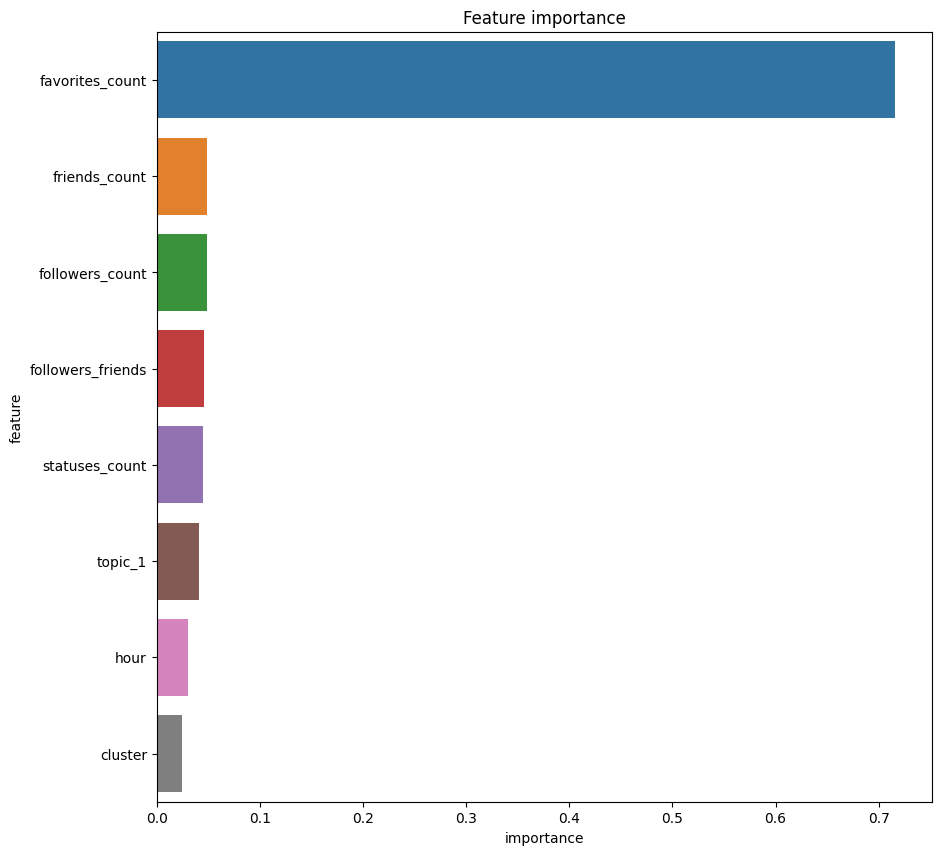

<AxesSubplot: >

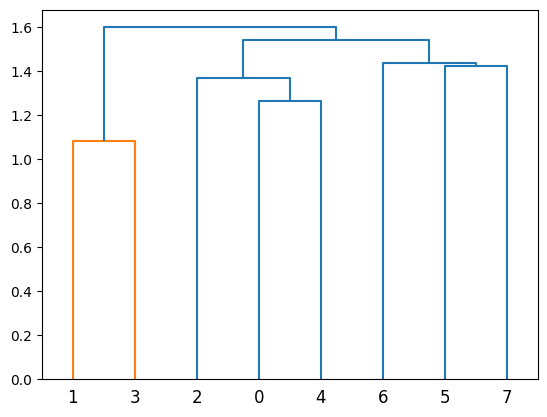

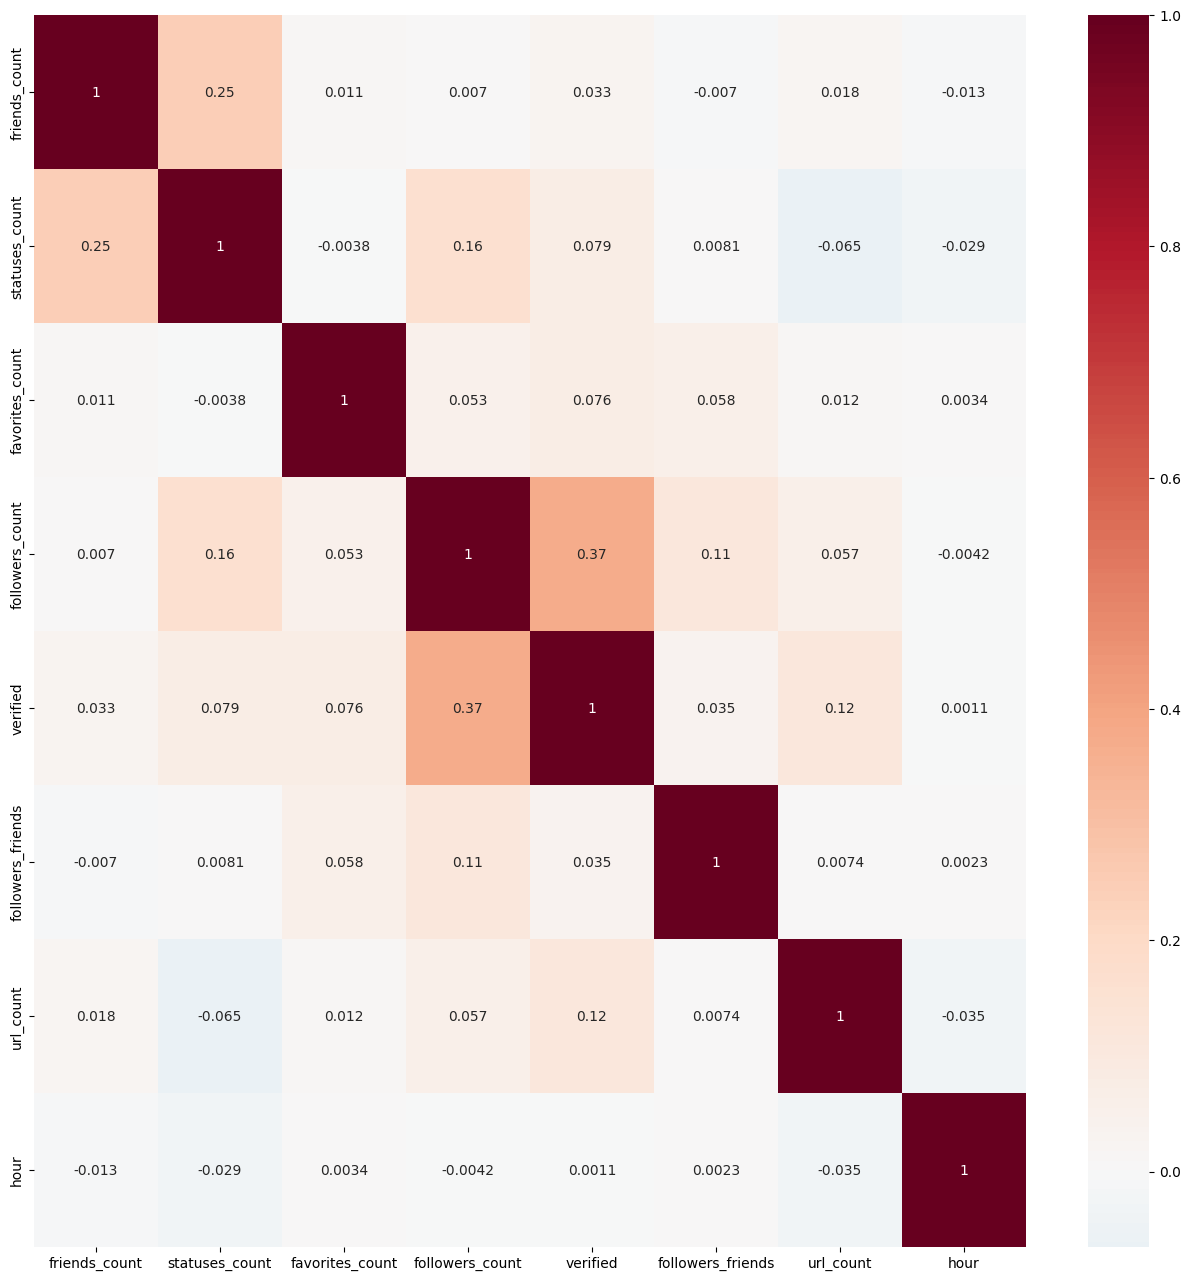

In [38]:
import seaborn as sbn
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
feature_importance = pd.DataFrame({'feature': new_X_train.drop(
    remove, axis=1).columns, 'importance': model.feature_importances_})
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance.sort_values(
    by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature importance')
plt.show()


# plot correlation of features

order = np.array(hierarchy.dendrogram(
    hierarchy.ward(new_X_train.drop(remove, axis=1).corr()), no_plot=False)['ivl'], dtype="int")

rearranged_cov = new_X_train.drop(
    ['TweetID'], axis=1).corr().iloc[order, order]

plt.figure(figsize=(16, 16))

sbn.heatmap(rearranged_cov, annot=True, cmap="RdBu_r", center=0)

In [39]:
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
2,favorites_count,0.715571
1,friends_count,0.049277
0,followers_count,0.048733
4,followers_friends,0.045780
3,statuses_count,0.045323
6,topic_1,0.041204
5,hour,0.029987
7,cluster,0.024125


In [40]:
# plot model mae with number of top features
# TO DO
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

i:
1
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]
8.128612594287652
i:
2
[[5.950e+02 0.000e+00]
 [2.900e+02 0.000e+00]
 [4.250e+02 0.000e+00]
 ...
 [4.001e+03 0.000e+00]
 [3.580e+02 0.000e+00]
 [2.276e+03 1.000e+00]]
7.874805774500664
i:
3
[[5.95000000e+02 0.00000000e+00 1.24217119e+00]
 [2.90000000e+02 0.00000000e+00 2.95616718e-01]
 [4.25000000e+02 0.00000000e+00 2.42027335e-01]
 ...
 [4.00100000e+03 0.00000000e+00 1.62708418e+00]
 [3.58000000e+02 0.00000000e+00 6.79316888e-01]
 [2.27600000e+03 1.00000000e+00 1.06008384e+00]]
7.747464474390485
i:
4
[[5.95000000e+02 4.78000000e+02 0.00000000e+00 1.24217119e+00]
 [2.90000000e+02 9.80000000e+02 0.00000000e+00 2.95616718e-01]
 [4.25000000e+02 1.75500000e+03 0.00000000e+00 2.42027335e-01]
 ...
 [4.00100000e+03 2.45800000e+03 0.00000000e+00 1.62708418e+00]
 [3.58000000e+02 5.26000000e+02 0.00000000e+00 6.79316888e-01]
 [2.27600000e+03 2.14600000e+03 1.00000000e+00 1.06008384e+00]]
7.447297793598327
i:
5
[[5.95000000e+02 4.78000000e+02 0.00000

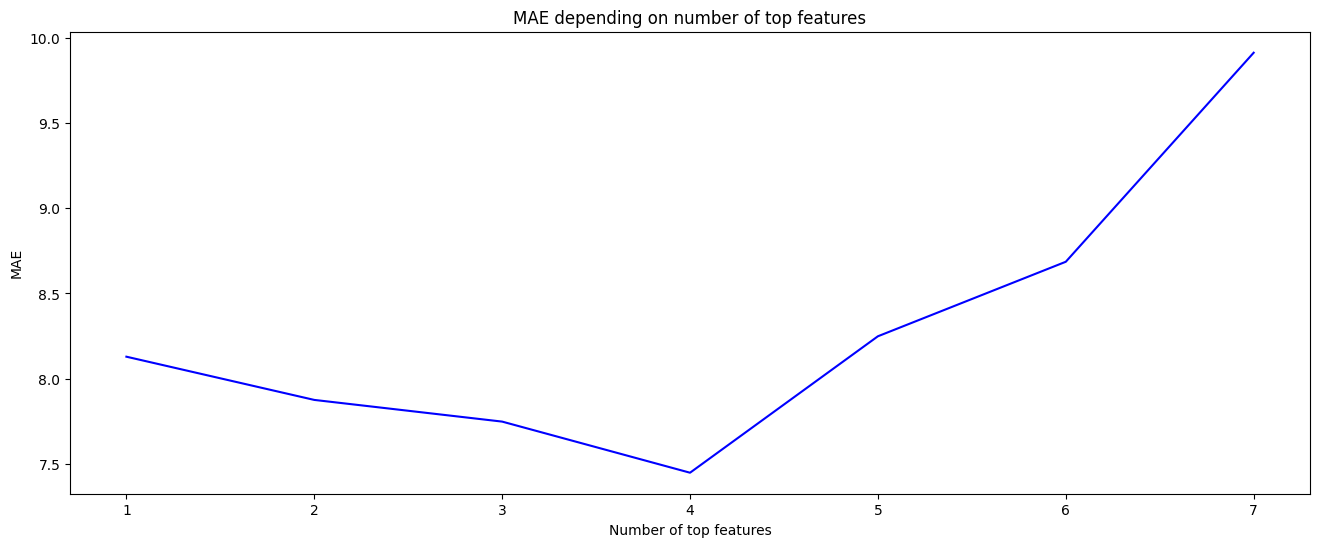

In [55]:
# plot model mae with number of top features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#from sklearn.neural_network import MLPRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
#from sklearn.ensemble import ExtraTreesRegressor

# The model
#model = automl.model.estimator

# Get Accuracy

acc = []
new_X_train2 = new_X_train.drop(remove, axis=1)
new_X_test2 = new_X_test.drop(remove, axis=1)

for i in range(1, len(col) - len(remove)):
    # apply SelectKBest class to extract top i best features
    k_best_fit = SelectKBest(score_func=f_regression, k=i).fit(new_X_train2, y_train)
    # transform both train and test
    X_train_new = k_best_fit.transform(new_X_train2)
    X_test_new = k_best_fit.transform(new_X_test2)
    # fit the model and predict
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    y_pred = [round(value) if value >= 0 else 0 for value in y_pred]
    acc.append(mean_absolute_error(y_test, y_pred))

# Plot
plt.figure(figsize=(16, 6))
plt.plot(range(1, len(col) - len(remove)), acc, c='b')
plt.title("MAE depending on number of top features")
plt.xlabel("Number of top features")
plt.ylabel("MAE")
plt.show()

# Get best features
k_best_fit = SelectKBest(score_func=f_regression, k=np.argmin(np.array(acc))).fit(new_X_train2, y_train)
n_best = 1 + np.argmin(np.array(acc))
best_features_names = [x for _, x in sorted(zip(k_best_fit.scores_, k_best_fit.feature_names_in_), reverse=True)][:n_best]
print(best_features_names)

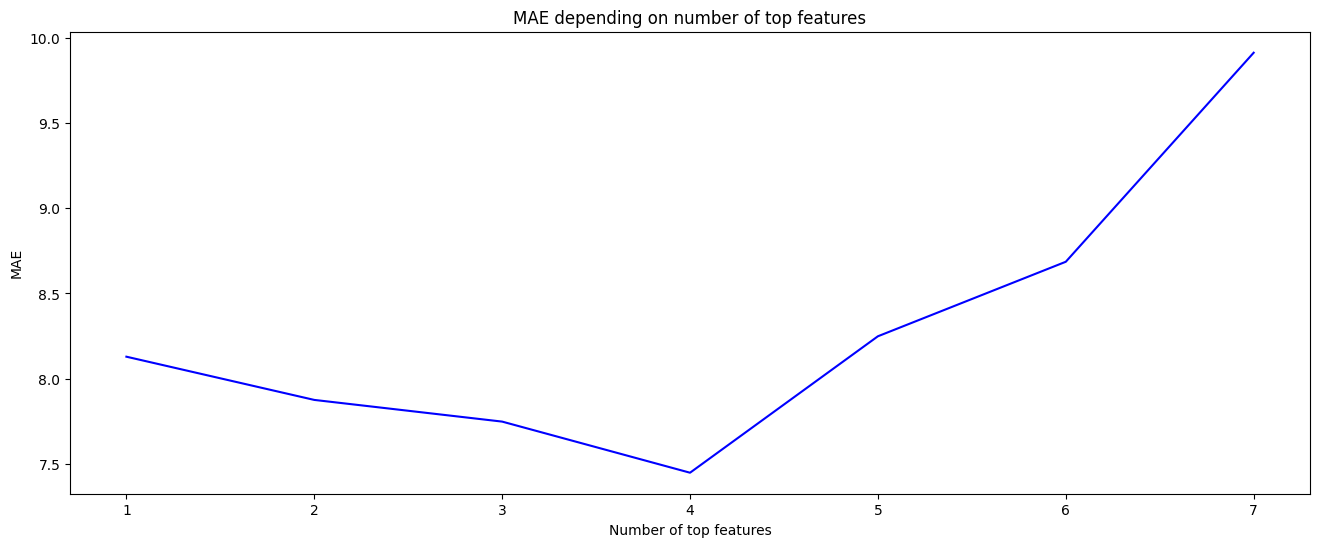

In [56]:
# Only the plot
plt.figure(figsize=(16, 6))
plt.plot(range(1, len(col) - len(remove)), acc, c='b')
plt.title("MAE depending on number of top features")
plt.xlabel("Number of top features")
plt.ylabel("MAE")
plt.show()

In [77]:
# Only the best features names
k_best_fit = SelectKBest(score_func=f_regression, k=np.argmin(np.array(acc))).fit(new_X_train2, y_train)
n_best = 1 + np.argmin(np.array(acc))
best_features_names = [x for _, x in sorted(zip(k_best_fit.scores_, k_best_fit.feature_names_in_), reverse=True)][:n_best]
print(best_features_names)

['favorites_count', 'followers_count', 'followers_friends', 'friends_count']


### Models to consider

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, new_X_train.drop(remove, axis=1), y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -10.268811 (1.497763)
ScaledLASSO: -10.202536 (1.523419)
ScaledEN: -14.474636 (1.714750)


KeyboardInterrupt: 